<a href="https://colab.research.google.com/github/AlirezaSamari/DeepLearning-Pytorch-fastai-and/blob/main/08_Using_fastai_and_PyTorch_framework_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

import opendatasets as od
od.download(
    "https://www.kaggle.com/competitions/titanic/data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./titanic" (use force=True to force download)


In [2]:
import pandas as pd
from fastai.tabular.all import *
from fastai import * 

In [3]:
df = pd.read_csv('/content/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
splits = RandomSplitter(seed = 42)(df)
n_train, n_test = splits

In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [6]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [7]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0831763744354248, valley=0.009120108559727669)

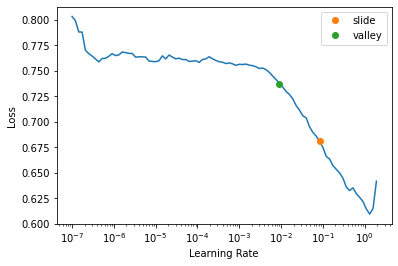

In [8]:
learn.lr_find(suggest_funcs=[slide, valley])

In [9]:
lr = 0.05

In [10]:
learn.fit(16, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.557410,0.638447,0.752809,00:00
1,0.490056,0.486970,0.786517,00:00
2,0.464565,0.429870,0.831461,00:00
3,0.441032,0.448117,0.825843,00:00
4,0.424848,0.418588,0.831461,00:00
5,0.419776,0.413983,0.814607,00:00
6,0.412561,0.442840,0.825843,00:00
7,0.410014,0.418402,0.837079,00:00
8,0.408098,0.437177,0.848315,00:00
9,0.402327,0.425144,0.820225,00:00


In [11]:
test_df = pd.read_csv('/content/titanic/test.csv')
test_df['Fare'] = test_df.Fare.fillna(0)
add_features(test_df)

In [12]:
test_dl = learn.dls.test_dl(test_df)


In [13]:
preds,_ = learn.get_preds(dl = test_dl)

In [14]:
test_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = test_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [15]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
